In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import zipfile as zf
import os
import random
import shutil
from pathlib import Path

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from PIL import Image

## 1. Extract data

Extract the contents of "dataset-resized.zip".

In [6]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

The dataset-resized folder has six subfolders, listed below:

In [7]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', 'plastic', '.DS_Store', 'trash', 'metal', 'paper', 'glass']

## 2. Organize images into different folders

Split images up into train and test image folders with an 80-20 split.
First, define some functions to help with this:

In [8]:
## helper functions ##

## splits indices for a folder into train and test indices with random sampling
    ## input: folder path
    ## output: train and test indices    
def split_indices(folder,seed1):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.8*n))

    ## test indices
    test = list(set(full_set)-set(train))
    
    return(train,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, create a bunch of destination folders.  It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /test <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>

Each image file is just the material name and a number.  For example, "cardboard1.jpg".

In [9]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, test_ind = split_indices(source_folder,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    move_files(test_source_files,test_dest)

In [4]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/cjcj5/Desktop/AI Final/data')

In [6]:
train_path = path/'../data/train'
test_path = path/'../data/test'
IMG_WIDTH = 512
IMG_HEIGHT = 384
num_classes = 6

In [12]:
train_batch = ImageDataGenerator(featurewise_center=False,
                                 samplewise_center=False, 
                                 featurewise_std_normalization=False, 
                                 samplewise_std_normalization=False, 
                                 zca_whitening=False, 
                                 rotation_range=45, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 horizontal_flip=True, 
                                 vertical_flip=False).flow_from_directory(train_path, 
                                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                                          classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], 
                                                                          batch_size=50)

test_batch = ImageDataGenerator().flow_from_directory(test_path, 
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
                                                      batch_size=50)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [38]:
def cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, 3, 3, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation ='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
  
    model.add(Conv2D(128, (3, 3), activation ='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
  
    model.add(Conv2D(128, (3, 3), activation ='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    model.add(Dense(512, activation ='relu'))
    model.add(Dense(6, activation ="softmax"))
              
    model.summary()
              
    return model

In [95]:
def use_model(path):
  #from tensorflow.keras.preprocessing.image import img_to_array
  model = load_model('best_waste_classifier.h5')
  pic1 = plt.imread(path)
  pic = Image.open(path).resize((IMG_WIDTH, IMG_HEIGHT))
  plt.imshow(pic1)

  # Use the reshaped image to make a prediction with your model
  predicted_class = model.predict(pic)

  if predicted_class == 0:
      classes = 'Cardboard'
  elif predicted_class == 1:
      classes = 'Glass'
  elif predicted_class == 2:
      classes = 'Metal'
  elif predicted_class == 3:
      classes = 'Paper'
  elif predicted_class == 4:
      classes = 'Plastic'
  elif predicted_class == 5:
      classes = 'Trash'
  
  return classes
    
    #model = load_model('best_waste_classifier.h5')
    #pic = plt.imread(path)
    #pic = cv2.resize(pic, (IMG_WIDTH, IMG_HEIGHT))
    #pic = np.expand_dims(pic, axis=0)
    #classes = model.predict_classes(pic)

In [2]:
def use_model(path):
  model = load_model('best_waste_classifier.h5')
  pic = plt.imread(path)
  plt.imshow(pic)
  pic = cv2.resize(pic, (IMG_WIDTH, IMG_HEIGHT))
  pic = np.expand_dims(pic, axis=0)
  predicted_class = np.argmax(model.predict(pic))

  if predicted_class == 0:
      classes = 'Cardboard'
  elif predicted_class == 1:
      classes = 'Glass'
  elif predicted_class == 2:
      classes = 'Metal'
  elif predicted_class == 3:
      classes = 'Paper'
  elif predicted_class == 4:
      classes = 'Plastic'
  elif predicted_class == 5:
      classes = 'Trash'
      
  return classes

In [39]:
model = cnn_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 170, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 83, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 39, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 19, 128)     

In [40]:
checkpoint = ModelCheckpoint('best_waste_classifier.h5', 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True, 
                             mode='auto')

In [41]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [42]:
# train the neural network

model = model.fit(train_batch,  
           validation_data=test_batch,  
           epochs=60, 
           verbose=1, 
           callbacks=[checkpoint],
           shuffle=True)

Epoch 1/60
41/41 [==============================] - 80s 2s/step - loss: 17.2371 - accuracy: 0.2080 - val_loss: 1.7167 - val_accuracy: 0.2598
Epoch 2/60
41/41 [==============================] - 78s 2s/step - loss: 1.6580 - accuracy: 0.2853 - val_loss: 1.5704 - val_accuracy: 0.3780
Epoch 3/60
41/41 [==============================] - 77s 2s/step - loss: 1.5745 - accuracy: 0.3328 - val_loss: 1.4402 - val_accuracy: 0.4094
Epoch 4/60
41/41 [==============================] - 79s 2s/step - loss: 1.4464 - accuracy: 0.3928 - val_loss: 1.4083 - val_accuracy: 0.4094
Epoch 5/60
41/41 [==============================] - 77s 2s/step - loss: 1.4479 - accuracy: 0.3903 - val_loss: 1.3418 - val_accuracy: 0.4724
Epoch 6/60
41/41 [==============================] - 78s 2s/step - loss: 1.3818 - accuracy: 0.4260 - val_loss: 1.3530 - val_accuracy: 0.4547
Epoch 7/60
41/41 [==============================] - 77s 2s/step - loss: 1.3714 - accuracy: 0.4393 - val_loss: 1.3447 - val_accuracy: 0.4488
Epoch 8/60
41/41 [=

1/1 [==============================] - 0s 111ms/step
Metal


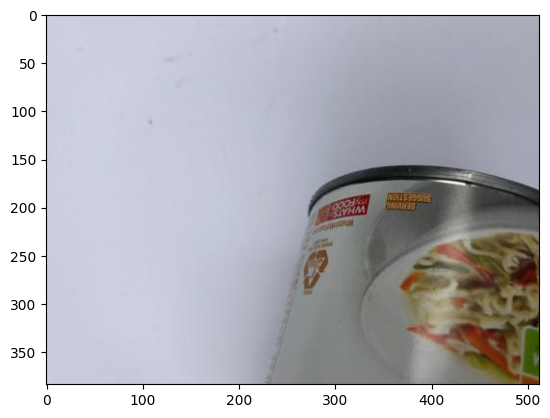

In [7]:
print(use_model(path/'../metal59.jpg'))

1/1 [==============================] - 0s 74ms/step
Metal


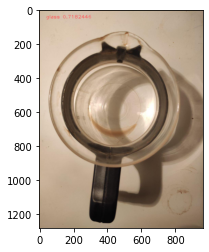

In [104]:
print(use_model(path/'../photo_2020-06-02_19-51-39.jpg'))

1/1 [==============================] - 0s 71ms/step
Metal


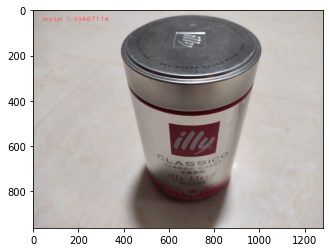

In [105]:
print(use_model(path/'../photo_2020-06-02_19-51-44 (2).jpg'))

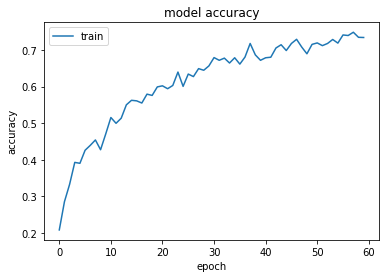

In [44]:
# Plot model's accuracy through epochs

plt.plot(model.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict([test_images])


## Run the following and upload an image to get results

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import zipfile as zf
import os
import random
import shutil
from pathlib import Path

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from PIL import Image

## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

train_path = path/'../data/train'
test_path = path/'../data/test'
IMG_WIDTH = 512
IMG_HEIGHT = 384
num_classes = 6

def use_model(path):
  model = load_model('best_waste_classifier.h5')
  pic = plt.imread(path)
  plt.imshow(pic)
  pic = cv2.resize(pic, (IMG_WIDTH, IMG_HEIGHT))
  pic = np.expand_dims(pic, axis=0)
  predicted_class = np.argmax(model.predict(pic))

  if predicted_class == 0:
      classes = 'Cardboard'
  elif predicted_class == 1:
      classes = 'Glass'
  elif predicted_class == 2:
      classes = 'Metal'
  elif predicted_class == 3:
      classes = 'Paper'
  elif predicted_class == 4:
      classes = 'Plastic'
  elif predicted_class == 5:
      classes = 'Trash'
      
  return classes

In [10]:
from IPython.display import FileUpload

upload_widget = FileUpload()
upload_widget

ImportError: cannot import name 'FileUpload' from 'IPython.display' (C:\Users\cjcj5\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\display.py)